# COx index timeplot

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import zoll
from utils import nirs
from utils import misc
from utils.autoscale import autoscale

In [2]:
# parameters
case_id = 1
step_id = 6

In [3]:
case_str = str(case_id).zfill(5)
output_file = f'output/{case_str}_{step_id}.csv'
input_file = 'output/' + case_str + '_5.csv'

In [4]:
# load data
df = pd.read_csv(input_file,
                 sep = ',',
                 na_values = ['-'],
                 parse_dates = ['Time'],
                 index_col = 'Time')
#mark_timestamp = df.loc[df['Mark'] == 1].index[0]

In [5]:
# dropout
df['rSO2_dropout'] = np.where(df['Bad_rSO2_manual'] == 1, np.nan, df['rSO2'])
df['MAP_dropout'] = np.where(df['Bad_MAP_auto'] == 1, np.nan, df['MAP'])
df['MAP_dropout'] = np.where(df['Bad_MAP_manual'] == 1, np.nan, df['MAP_dropout'])

In [6]:
# smooth rSO2 to match MAP
df['rSO2_dropout'] = df['rSO2_dropout'].rolling(10).mean()

In [7]:
# resampling as per Ono, Joshi, Brady, Easley et al. 2012
resampled_df = pd.DataFrame()
resampled_df['MAP'] = df['MAP_dropout'].resample('10s').mean()
resampled_df['rSO2'] = df['rSO2_dropout'].resample('10s').mean()

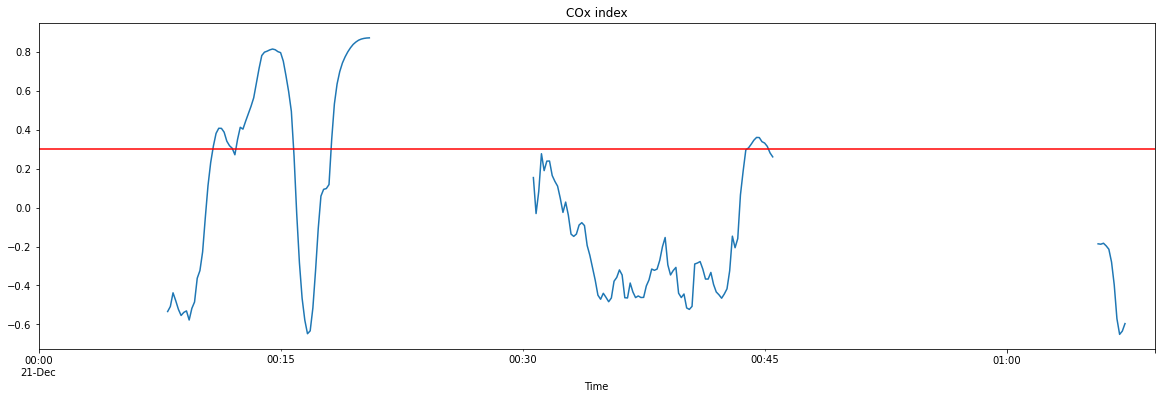

In [8]:
resampled_df['COx'] = resampled_df['rSO2'].rolling(30).corr(resampled_df['MAP'])
resampled_df['COx'].plot(figsize=(20,6), title="COx index")
plt.axhline(0.3, color="red")

In [9]:
df['COx'] = df['rSO2_dropout'].rolling(300).corr(df['MAP_dropout'])

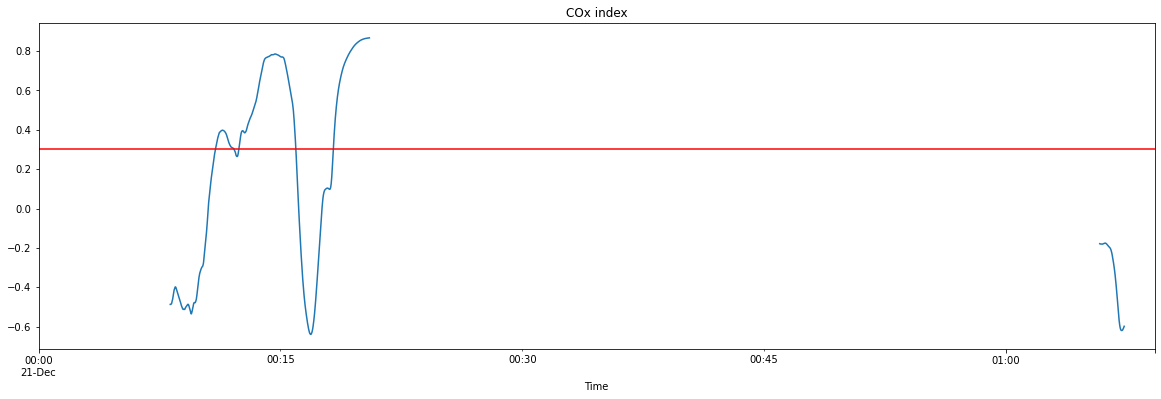

In [10]:
df['COx'].plot(figsize=(20,6), title="COx index")
plt.axhline(0.3, color="red")
plt.savefig(f'reports/images/{step_id}_{case_str}_01.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

No big difference between resampled and unresampled curve. Resampling is good for (scatter)plots over MAP axis, no need in a timeplot.

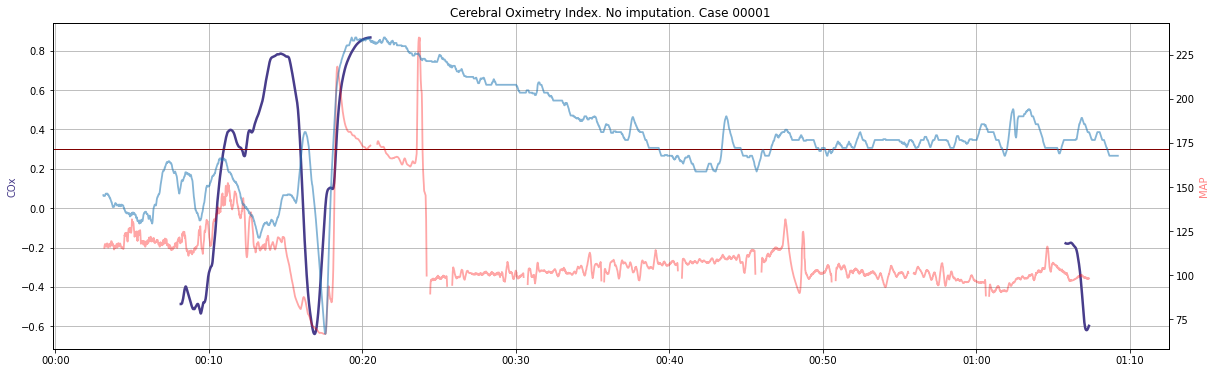

In [11]:
fig, ax1 = plt.subplots(figsize=(20,6))
ax1.set_ylabel('COx', color='darkslateblue')
ax1.plot(df.index, df['COx'], linewidth=2.5, color='darkslateblue')
ax2 = ax1.twinx()
ax2.plot(df.index, df['MAP_dropout'], linewidth=1.8, alpha=0.35, color='red')
ax2.set_ylabel('MAP', color="red", alpha=0.5)
ax3 = ax1.twinx()
ax3.plot(df.index, df['rSO2_dropout'], linewidth=1.8, alpha=0.55)
ax3.set_yticks([])
ax1.grid()
ax1.axhline(0.3, linewidth=1, color="maroon")
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
plt.title(f'Cerebral Oximetry Index. No imputation. Case {case_str}')
plt.savefig(f'reports/images/{step_id}_{case_str}_01.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [12]:
df['MAP_interpolated'] = df['MAP_dropout'].interpolate(limit_area='inside')
df['rSO2_interpolated'] = df['rSO2_dropout'].interpolate(limit_area='inside')
df['COx_interpolated'] = df['rSO2_interpolated'].rolling(300).corr(df['MAP_interpolated'])

In [13]:
cox_critical = (df['COx_interpolated'] >= 0.30).sum()
cox_defined = df['COx_interpolated'].count()
cox_above_threshold = cox_critical / cox_defined

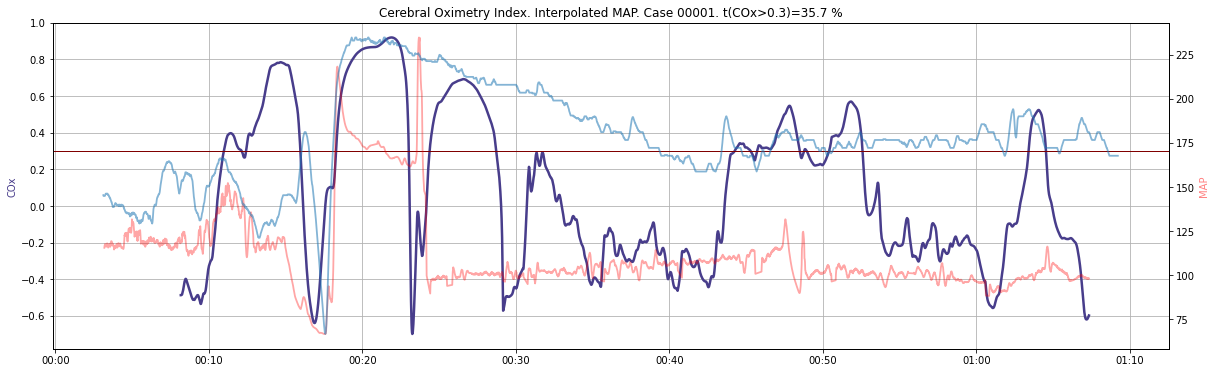

In [14]:
fig, ax1 = plt.subplots(figsize=(20,6))
ax1.set_ylabel('COx', color='darkslateblue')
ax1.plot(df.index, df['COx_interpolated'], linewidth=2.5, color='darkslateblue')
ax2 = ax1.twinx()
ax2.plot(df.index, df['MAP_interpolated'], linewidth=1.8, alpha=0.35, color='red')
ax2.set_ylabel('MAP', color="red", alpha=0.5)
ax3 = ax1.twinx()
ax3.plot(df.index, df['rSO2_interpolated'], linewidth=1.8, alpha=0.55)
ax3.set_yticks([])
ax1.grid()
ax1.axhline(0.3, linewidth=1, color="maroon")
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
plt.title(f'Cerebral Oximetry Index. Interpolated MAP. Case {case_str}. t(COx>0.3)={cox_above_threshold*100:.1f} %')
plt.savefig(f'reports/images/{step_id}_{case_str}_02.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [15]:
# save output
df['COx'] = df['COx_interpolated']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df[['MAP', 'Bad_MAP_auto', 'Bad_MAP_manual', 'rSO2', 'Mark', 'Bad_rSO2_auto', 'Bad_rSO2_manual', 'COx', 'MAP_delay']].to_csv(output_file, na_rep='-', date_format='%H:%M:%S')